# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [1]:
# loading libraries and data

%matplotlib inline

import sqlite3                          # for sql database
import pandas as pd
import numpy as np
import nltk                             # nltk:- Natural Language Processing Toolkit
import string
import re
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import pickle
def saveindisk(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromdisk(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

con = sqlite3.connect("database.sqlite")

# Filtering only positive and negative reviews that is
# not taking into consideration those reviews with score = 3
df = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)


# Give reviews with score > 3 to be positive rating and reviews with a score < 3 as a negative
def polarity(x):
    if x < 3:
        return 'Negative'
    else:
        return 'Positive'
df["Score"] = df["Score"].map(polarity) # map is use to assign in all the Score

In [2]:
df.head() # top 5 values

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,525814.000000,525814.000000,525814.000000,5.258140e+05
mean,284599.060038,1.747293,2.209544,1.295943e+09
std,163984.038077,7.575819,8.195329,4.828129e+07
min,1.000000,0.000000,0.000000,9.393408e+08
25%,142730.250000,0.000000,0.000000,1.270598e+09
50%,284989.500000,0.000000,1.000000,1.310861e+09
75%,426446.750000,2.000000,2.000000,1.332634e+09
max,568454.000000,866.000000,878.000000,1.351210e+09


In [4]:
df.shape
df['Score'].size

525814

In [6]:
df['Score'].value_counts()

Positive    443777
Negative     82037
Name: Score, dtype: int64

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

## *1) Data Cleaning*

###  Data Deduplication

In [7]:
df.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts() # checking duplicates

False    364173
True     161641
dtype: int64

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [9]:
df1 =  df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first") # Deleting all the duplicates

In [10]:
size_diff = df1['Id'].size/df['Id'].size

###  Helpfullness Numerator Greater than Helpfullness Denominator

* HelpfulnessNumerator = (Yes) Review is good or not
* HelpfulnessDenominator = (Yes + No) Review is good or not

In [11]:
filtered_data2 = df1[df1.HelpfulnessNumerator <= df1.HelpfulnessDenominator]

## *2) Text Preprocessing*

### HTML Tag Removal

In [12]:
# A regular expression (or RE) specifies a set of strings that matches it; the functions in this module let you check if a particular string matches a given regular expression (or if a given regular expression matches a particular string, which comes down to the same thing).
import re
# cleaning html symbols from the sentence
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext


### Punctuations Removal

In [13]:
# cleaning punctuations from the sentence
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

### Stopwords
* A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

![alt text](https://www.geeksforgeeks.org/wp-content/uploads/Stop-word-removal-using-NLTK.png)

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english')
print(stop)

[nltk_data] Error loading stopwords: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', '

###  Stemming
* A word stem is part of a word. It is sort of a normalization idea, but linguistic.
For example, the stem of the word waiting is wait.

![alt text](https://pythonspot-9329.kxcdn.com/wp-content/uploads/2016/08/word-stem.png.webp)

In [15]:
from nltk.stem import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 
print(snow.stem('tasty'))

tasti


# Preprocessing on all the reviews

In [16]:
i = 0
string1 = ' '
final_string = []
all_positive_words = []                   # store words from +ve reviews here
all_negative_words = []                   # store words from -ve reviews here.
s = ''

for sent in filtered_data2['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    sent = cleanpunc(sent)
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):  
            if(w.lower() not in stop):    # If it is a stopword
                s = (snow.stem(w.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (filtered_data2['Score'].values)[i] == 'Positive':
                    all_positive_words.append(s)
                if(filtered_data2['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s)
            else:
                continue
        else:
            continue 
    string1 = b" ".join(filtered_sentence) 
    final_string.append(string1)
    i += 1

# Cleaned text Without Stemming for Google trained W2Vec

In [17]:
i = 0
string1 = ' '
final_string_nostem = []
s = ''

for sent in filtered_data2['Text'].values:
    filtered_sentence=[]
    sent = cleanhtml(sent)
    sent = cleanpunc(sent)
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):  
            if(w.lower() not in stop):
                s = w.lower().encode('utf8')
                filtered_sentence.append(s)
            else:
                continue
        else:
            continue 
    string1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(string1)
    i += 1

# Postive and Negative words in reviews

In [18]:
from collections import Counter
print("Number of positive words:",len(all_positive_words))
print("Number of negative words:", len(all_negative_words))

Number of positive words: 11610405
Number of negative words: 2354587


# Storing our preprocessed data in Database

In [19]:
filtered_data2['CleanedText'] = final_string
filtered_data2['CleanedText_NoStem'] = final_string_nostem
filtered_data2.head(3)


/anaconda3/envs/Vj/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/Vj/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...,b'product arrived labeled jumbo salted peanuts...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...


In [20]:
filtered_data2['CleanedText_NoStem'][1]

b'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'

In [21]:
con = sqlite3.connect('final.sqlite')
con.text_factory = str
filtered_data2.to_sql('Reviews', con,if_exists='replace')

In [22]:
con = sqlite3.connect("final.sqlite")
filtered_data2 = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

# Ways to convert text to vector
## *1) Uni-gram BOW*

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
filtered_data2['CleanedText'].values

array([ b'bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better',
       b'product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo',
       b'confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori lewi lion witch wardrob treat seduc edmund sell brother sister witch',
       ...,
       b'star small give one train session tri train dog ceaser dog treat made puppi hyper compar ingredi know littl star basic food ingredi without preserv food color sweet potato flavor also make hand smell like dog food',
       b'best treat train reward dog good groom lower calori love doggi sweet potato seem favorit wet nose treat',
       b'satisfi product advertis use cereal raw vinegar general sweetner'], dtype=object)

In [25]:
uni_gram = CountVectorizer()
uni_gram_vectors = uni_gram.fit_transform(filtered_data2['CleanedText'].values)

In [26]:
saveindisk(uni_gram_vectors,"uni_gram")

In [27]:
#Loading the variable from file
uni_gram_vectors = openfromdisk("uni_gram")

In [28]:
uni_gram_vectors.shape[1]

71624

In [29]:
uni_gram_vectors[0]

<1x71624 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [30]:
type(uni_gram_vectors)

scipy.sparse.csr.csr_matrix

In [31]:
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=2)
tsvd_uni_vec = tsvd_uni.fit_transform(uni_gram_vectors)

In [32]:
saveindisk(tsvd_uni,"tsvd_uni")
saveindisk(tsvd_uni_vec,"tsvd_uni_vec")

In [33]:
tsvd_uni = openfromdisk("tsvd_uni")
tsvd_uni_vec = openfromdisk("tsvd_uni_vec")

In [34]:
tsvd_uni.explained_variance_ratio_[:].sum()

0.064324302977208064

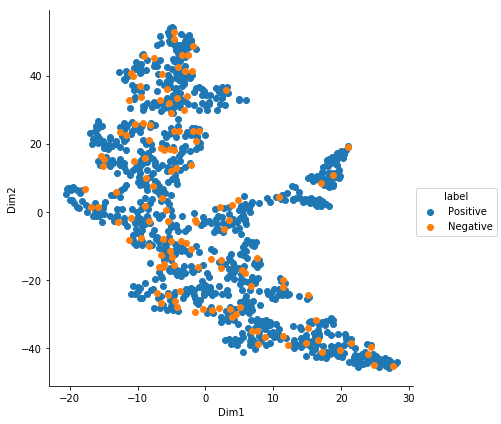

In [35]:
# Perplexity = 40

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=40)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

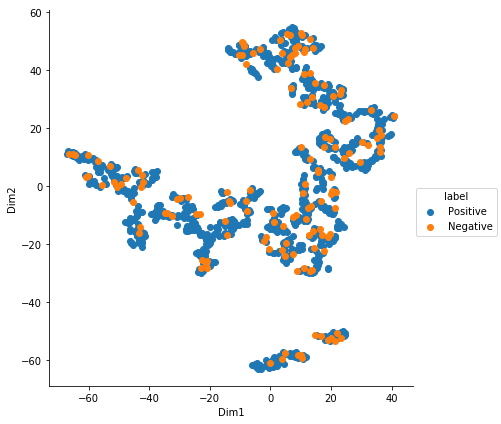

In [37]:
# Perplexity = 30

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

## *2) Bi-gram BOW*

In [38]:
bi_gram = CountVectorizer(ngram_range=(1,2))
bi_gram_vectors = bi_gram.fit_transform(filtered_data2['CleanedText'].values)

In [39]:
saveindisk(bi_gram_vectors,"bi_gram")

In [40]:
bi_gram_vectors = openfromdisk("bi_gram")

In [41]:
bi_gram_vectors.shape 

(364171, 2923725)

In [42]:
type(bi_gram_vectors)

scipy.sparse.csr.csr_matrix

In [43]:
from sklearn.decomposition import TruncatedSVD
sample_points = filtered_data2.sample(1100)

bi_gram = CountVectorizer(ngram_range=(1,2))
bi_gram_vectors = bi_gram.fit_transform(sample_points['CleanedText'])
tsvd_bi = TruncatedSVD(n_components=2)
tsvd_bi_vec = tsvd_bi.fit_transform(bi_gram_vectors)

In [44]:
saveindisk(tsvd_bi, "tsvd_bi")
saveindisk(tsvd_bi_vec, "tsvd_bi_vec")

In [45]:
tsvd_bi = openfromdisk("tsvd_bi")
tsvd_bi_vec = openfromdisk("tsvd_bi_vec")

In [46]:
tsvd_bi.explained_variance_ratio_[:].sum()

0.064812388597165163

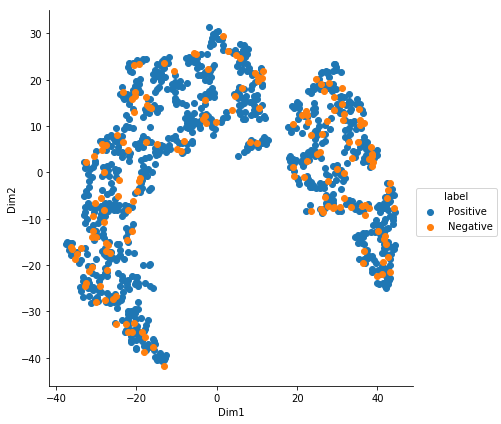

In [47]:
# Perplexity = 30

from sklearn.manifold import TSNE
from time import time
import random

n_samples = 1000
sample_cols = random.sample(range(1, tsvd_bi_vec.shape[0]), n_samples)
sample_features = tsvd_bi_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

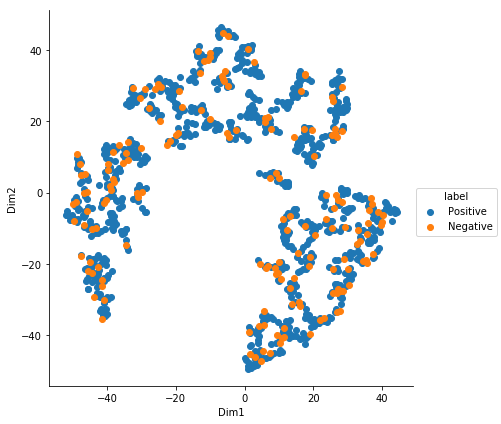

In [48]:
# Perplexity = 20

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tsvd_bi_vec.shape[0]), n_samples)
sample_features = tsvd_bi_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

## *3) tf-idf*

* TF*IDF is an information retrieval technique that weighs a term's frequency (TF) and its inverse document frequency (IDF). Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF*IDF weight of that term

![alt text](https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png)

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_vec = tfidf.fit_transform(filtered_data2['CleanedText'])

In [50]:
saveindisk(tfidf_vec,"tfidf")

In [51]:
tfidf_vec = openfromdisk("tfidf")

In [52]:
tfidf_vec.shape

(364171, 2923725)

In [53]:
features = tfidf.get_feature_names()
features[190000:190010]

['barista pour',
 'barista prepar',
 'barista prima',
 'barista primia',
 'barista pull',
 'barista realli',
 'barista recip',
 'barista recommend',
 'barista run',
 'barista said']

In [54]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ind = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ind]
    df = pd.DataFrame(top_feats,columns = ['feature', 'tfidf'])
    return df
top_tfidfs = top_tfidf_feats(tfidf_vec[1000,:].toarray()[0],features,20)

In [55]:
from sklearn.decomposition import TruncatedSVD

tsvd_tfidf = TruncatedSVD(n_components=2)
tsvd_tfidf_vec = tsvd_tfidf.fit_transform(tfidf_vec)

In [56]:
saveindisk(tsvd_tfidf,"tsvd_tfidf")
saveindisk(tsvd_tfidf_vec,"tsvd_tfidf_vec")

In [57]:
tsvd_tfidf_vec = openfromdisk("tsvd_tfidf_vec")
tsvd_tfidf = openfromdisk("tsvd_tfidf")

In [58]:
tsvd_tfidf.explained_variance_ratio_[:].sum() 

0.0031611495613284375

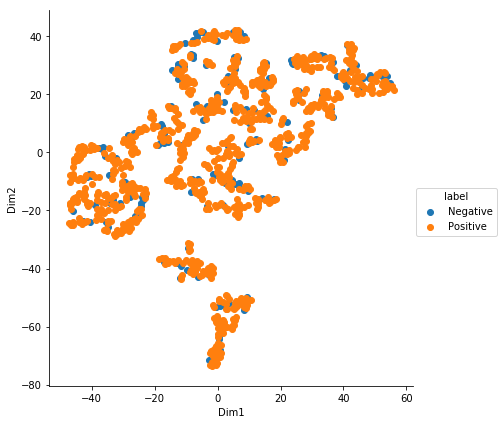

In [59]:
# Perplexity = 20

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tsvd_tfidf_vec.shape[0]), n_samples)
sample_features = tsvd_tfidf_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

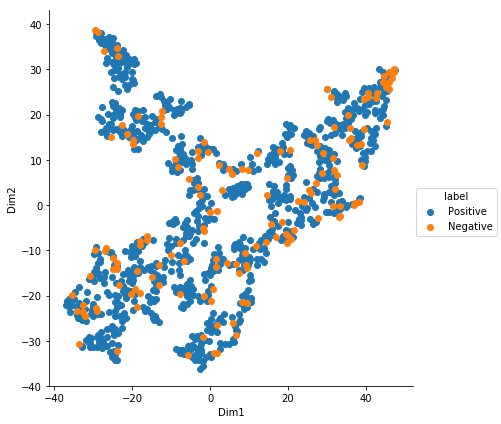

In [60]:
# Perplexity = 30 

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tsvd_tfidf_vec.shape[0]), n_samples)
sample_features = tsvd_tfidf_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

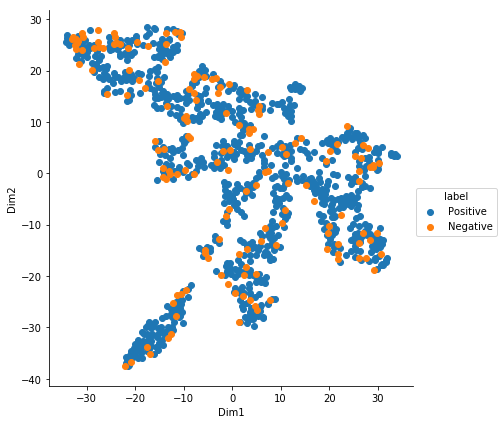

In [61]:
# Perplexity = 40

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tsvd_tfidf_vec.shape[0]), n_samples)
sample_features = tsvd_tfidf_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=40)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

### *4) Word2Vec*

* word2vec is an algorithm for constructing vector representations of words, also known as word embeddings. The vector for each word is a semantic description of how that word is used in context, so two words that are used similarly in text will get similar vector represenations. Once you map words into vector space, you can then use vector math to find words that have similar semantics.

In [62]:
final_string = []
for sent in filtered_data2['CleanedText'].values:
    sent = str(sent)
    sentence = []
    for word in sent.split():
        sentence.append(word)
    final_string.append(sentence)

In [63]:
import gensim # In gensim a corpus is simply an object which, when iterated over, returns its documents represented as sparse vectors.

w2v_model = gensim.models.Word2Vec(final_string,min_count=5,size=50, workers=4)

In [64]:
w2v_model.save('w2vmodel')

In [65]:
w2v_model = gensim.models.Word2Vec.load('w2vmodel')

In [66]:
w2v_vocub = w2v_model.wv.vocab
len(w2v_vocub)

28277

In [67]:
w2v_model.wv.most_similar('tast')

[("tast'", 0.8238769769668579),
 ("b'tast", 0.8226029872894287),
 ('flavor', 0.778342068195343),
 ('aftertast', 0.7768616080284119),
 ("aftertast'", 0.7289929986000061),
 ('tase', 0.6916904449462891),
 ("b'flavor", 0.679926872253418),
 ('textur', 0.655602216720581),
 ('flavour', 0.6538017988204956),
 ('kind', 0.6423604488372803)]

## *5) Avg Word2Vec*

* It is the average of Word2Vec

In [68]:
avg_vec = []
for sent in final_string:
    cnt = 0
    sent_vec = np.zeros(50)
    for word in sent:
        try:
            wvec = w2v_model.wv[word]
            sent_vec += wvec
            cnt += 1
        except: 
            pass
    sent_vec /= cnt
    avg_vec.append(sent_vec)

/anaconda3/envs/Vj/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [69]:
saveindisk(avg_vec,"avg_w2v_vec")

In [70]:
avg_vec = openfromdisk("avg_w2v_vec")

In [71]:
avg_vec = np.array(avg_vec)
avg_vec.shape

(364171, 50)

In [72]:
avg_vec

array([[ 0.8301368 ,  0.23754464, -0.74297137, ..., -0.46162309,
         0.44133274,  1.20804154],
       [ 1.052849  ,  1.13297069,  0.50683935, ..., -0.21010254,
         1.83036049,  0.76791109],
       [-0.16824441,  0.26793146, -0.0247929 , ..., -0.29860936,
         0.28414198,  0.661253  ],
       ..., 
       [ 0.29631629,  0.27325264, -0.32920101, ..., -1.14248099,
         0.59442838,  1.49481666],
       [-0.46872838,  0.07106789, -0.64326881, ..., -0.16686433,
        -0.36505715,  1.60269693],
       [ 0.93998764,  0.58816517,  0.33524912, ..., -0.87432795,
         0.5708223 , -0.63238705]])

In [73]:
np.any(np.isnan(avg_vec))

True

In [74]:
np.all(np.isfinite(avg_vec))

False

In [75]:
col_mean = np.nanmean(avg_vec, axis=0)

In [76]:
inds = np.where(np.isnan(avg_vec))
inds

(array([130004, 130004, 130004, 130004, 130004, 130004, 130004, 130004,
        130004, 130004, 130004, 130004, 130004, 130004, 130004, 130004,
        130004, 130004, 130004, 130004, 130004, 130004, 130004, 130004,
        130004, 130004, 130004, 130004, 130004, 130004, 130004, 130004,
        130004, 130004, 130004, 130004, 130004, 130004, 130004, 130004,
        130004, 130004, 130004, 130004, 130004, 130004, 130004, 130004,
        130004, 130004, 142808, 142808, 142808, 142808, 142808, 142808,
        142808, 142808, 142808, 142808, 142808, 142808, 142808, 142808,
        142808, 142808, 142808, 142808, 142808, 142808, 142808, 142808,
        142808, 142808, 142808, 142808, 142808, 142808, 142808, 142808,
        142808, 142808, 142808, 142808, 142808, 142808, 142808, 142808,
        142808, 142808, 142808, 142808, 142808, 142808, 142808, 142808,
        142808, 142808, 142808, 142808, 152642, 152642, 152642, 152642,
        152642, 152642, 152642, 152642, 152642, 152642, 152642, 

In [77]:
avg_vec[inds] = np.take(col_mean, inds[1])


In [78]:
np.any(np.isnan(avg_vec))

False

In [79]:
from sklearn import preprocessing
avg_vec_norm = preprocessing.normalize(avg_vec)

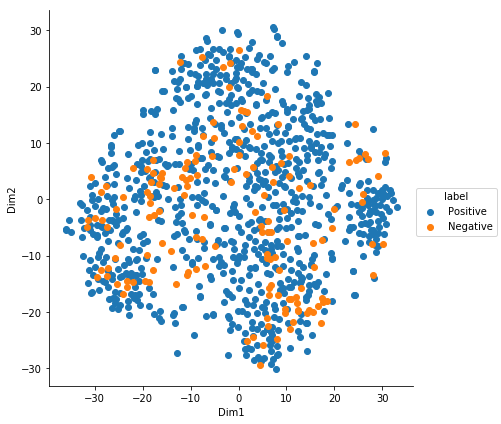

In [80]:
# Perplexity = 30

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec.shape[0]), n_samples)
sample_features = avg_vec[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

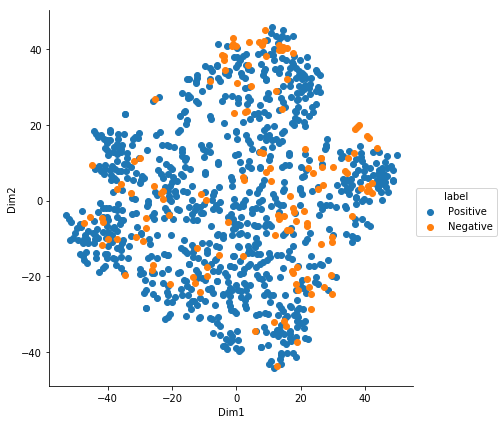

In [111]:
# Perplexity = 20

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_norm.shape[0]), n_samples)
sample_features = avg_vec_norm[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

# *6) Using Google's Trained W2Vec on Google News*

In [83]:
from gensim.models import KeyedVectors
w2v_model_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [84]:
w2v_model_google.wv.most_similar('like')

/anaconda3/envs/Vj/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('really', 0.5752447843551636),
 ('weird', 0.5676319599151611),
 ('crazy', 0.5382446646690369),
 ('kind', 0.5310239791870117),
 ('maybe', 0.5220046043395996),
 ('loooove', 0.5187615156173706),
 ('anymore', 0.5177682638168335),
 ('Kinda_reminds', 0.5151873230934143),
 ('definitely', 0.5117844343185425),
 ('kinda_fishy', 0.5090124607086182)]

In [85]:
w2v_model_google.wv["word"].size

/anaconda3/envs/Vj/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


300

In [86]:
import random
avg_vec_google = []
datapoint = 3000
sample_cols = random.sample(range(1, datapoint), 1001)

for sent in filtered_data2['CleanedText_NoStem'].values[sample_cols]:
    cnt = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
            wvec = w2v_model_google.wv[word]
            sent_vec += wvec
            cnt += 1
        except: 
            pass
    sent_vec /= cnt
    avg_vec_google.append(sent_vec)
avg_vec_google = np.array(avg_vec_google)

/anaconda3/envs/Vj/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [87]:
saveindisk(avg_vec_google,"avg_w2v_vec_google")

In [88]:
avg_vec_google = openfromdisk("avg_w2v_vec_google")

In [89]:
np.any(np.isnan(avg_vec_google))

False

In [90]:
np.all(np.isfinite(avg_vec_google))

True

In [91]:
col_mean = np.nanmean(avg_vec_google, axis=0)

In [92]:
inds = np.where(np.isnan(avg_vec_google)) 
inds

(array([], dtype=int64), array([], dtype=int64))

In [93]:
avg_vec_google[inds] = np.take(col_mean, inds[1])


In [94]:
avg_vec_google

array([[ 0.01509753,  0.01313868, -0.00987677, ..., -0.05414109,
         0.0138457 , -0.02766202],
       [-0.00668945,  0.00154622,  0.11971029, ..., -0.00633545,
        -0.00012716,  0.06525523],
       [-0.03954414,  0.08931068, -0.03622855, ...,  0.00103957,
         0.03189973,  0.01891056],
       ..., 
       [ 0.0043002 ,  0.07310486,  0.04706296, ..., -0.06181752,
         0.03754513,  0.00438343],
       [-0.02395015,  0.03252496, -0.00783793, ...,  0.00247023,
         0.05283356,  0.06517198],
       [ 0.00935465,  0.0388326 ,  0.05890198, ...,  0.0265096 ,
         0.08789062,  0.01531576]])

In [95]:
from sklearn import preprocessing
avg_vec_google_norm = preprocessing.normalize(avg_vec_google)

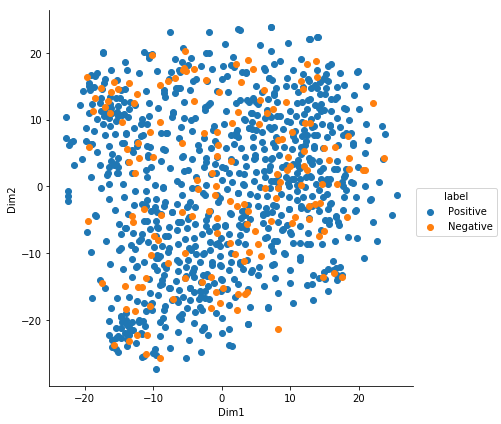

In [96]:
# Perplexity = 20

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

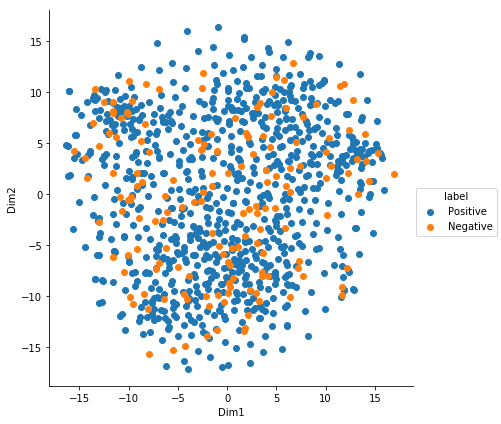

In [97]:
# Perplexity = 30

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]
sample_class = filtered_data2['Score'][sample_cols]

sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

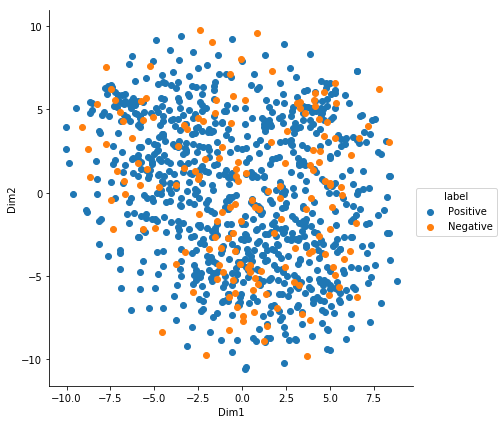

In [98]:
# Perplexity = 50

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]
sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=50)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

## *7) Tf-idf W2Vec*


In [99]:
datapoints = 3000
sample_cols = random.sample(range(1, datapoints), 1001)

In [100]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_vec_ns = tfidf.fit_transform(filtered_data2['CleanedText_NoStem'].values[sample_cols])
tsvd_tfidf_ns = TruncatedSVD(n_components=2)
tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)
features = tfidf.get_feature_names()

In [101]:
tfidf_w2v_vec_google = []
review = 0

for sent in filtered_data2['CleanedText_NoStem'].values[sample_cols]:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
            wvec = w2v_model_google.wv[word] 
            tfidf = tfidf_vec_ns[review,features.index(word)]
            sent_vec += (wvec * tfidf)
            weighted_sum += tfidf
        except:
            pass
    sent_vec /= weighted_sum
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1

/anaconda3/envs/Vj/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [102]:
len(tfidf_w2v_vec_google)

1001

In [103]:
len(tfidf_w2v_vec_google[0])

300

In [104]:
tfidf_w2v_vec_google[0]

array([ 0.01439151, -0.01776129,  0.02893841,  0.22971813,  0.00343937,
       -0.00373381,  0.0248765 , -0.11421477, -0.01218917,  0.16294069,
        0.04356164, -0.10843119,  0.04473864, -0.04198844, -0.15855499,
        0.13429914, -0.06114091,  0.12541666,  0.02830603, -0.1677314 ,
        0.01107036,  0.03407249,  0.04068124, -0.01304926, -0.00464823,
       -0.00565309, -0.06587132,  0.11856514, -0.106316  ,  0.04663358,
        0.01978987,  0.05380951,  0.02128574,  0.02182653,  0.00126964,
       -0.00368547,  0.13140673, -0.09667443,  0.10978316,  0.11071127,
        0.04303011, -0.07063573,  0.01400318,  0.02947633, -0.0615496 ,
       -0.22030344, -0.05270189,  0.03774665,  0.0767672 ,  0.08715285,
       -0.09861637,  0.05805197, -0.11958436, -0.03528834,  0.0638237 ,
        0.09738169, -0.05145475, -0.0656151 ,  0.03060007, -0.17452014,
       -0.10159841,  0.10509332, -0.10613771, -0.03611282,  0.06537362,
       -0.10154889, -0.06811263, -0.11842214,  0.14837591,  0.07

In [105]:
saveindisk(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

In [106]:
tfidf_w2v_vec_google = openfromdisk("tfidf_w2v_vec_google")

In [107]:
from sklearn import preprocessing
tfidf_w2v_vec_google_norm = preprocessing.normalize(tfidf_w2v_vec_google)

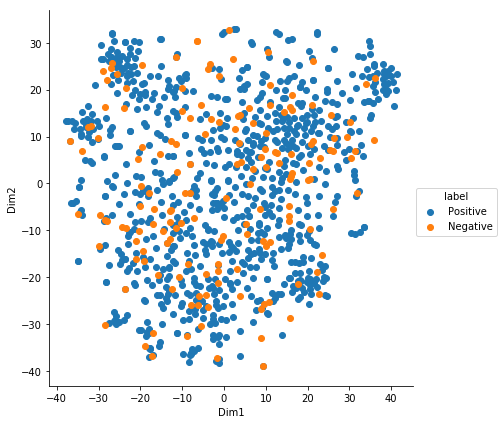

In [108]:
# Perplexity = 20

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tfidf_w2v_vec_google_norm.shape[0]), n_samples)
sample_features = tfidf_w2v_vec_google_norm[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

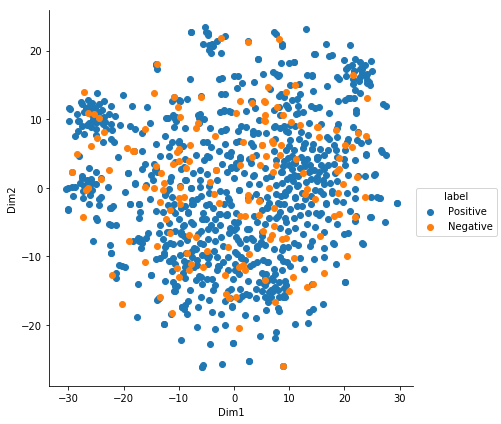

In [109]:
# Perplexity = 35

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tfidf_w2v_vec_google_norm.shape[0]), n_samples)
sample_features = tfidf_w2v_vec_google_norm[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=35)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

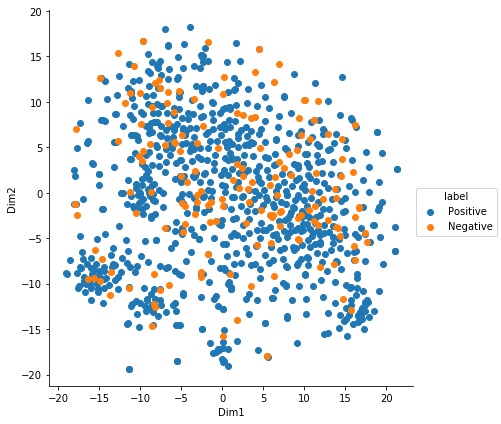

In [110]:
# Perplexity = 50

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, tfidf_w2v_vec_google_norm.shape[0]), n_samples)
sample_features = tfidf_w2v_vec_google_norm[sample_cols]

sample_class = filtered_data2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=50)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_data,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

# Conclusion:-
* As it is clearly visible from the overlapping area of the graph that bag of word and tf-IDF not classify the reviews positive or negative, while tfidf w2vec gives the more clear result in classifying the reviews as positive or negative.

# References:-
https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

https://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns